In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.model_selection import KFold
from os import path
from pydub import AudioSegment

import warnings
warnings.filterwarnings('ignore')

C:\Users\Guest1\anaconda3\envs\backup_20220216_20220322\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [130]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [131]:
data.shape

(8732, 8)

In [132]:
# Get data over 3 seconds long

valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

In [133]:
type(valid_data)

pandas.core.frame.DataFrame

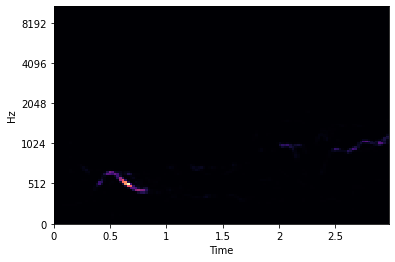

In [134]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

mel_sgram = librosa.amplitude_to_db(ps, ref=np.min)

librosa.display.specshow(ps , y_axis='mel', x_axis='time')

In [20]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [21]:
#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset

    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/augmented/ps2_m25/' + row.path, duration=2.97)  #2.97 = 3*1000 - 3*1000/128  ###############################
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D.append( (ps, row.classID) )
    np.save('train_data_augmented_ps2_m25.npy', D) ###############################
    return D

In [ ]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('train_data.npy')
b = np.load('train_data_augmented_speed_81.npy')
c = np.load('train_data_augmented_speed_107.npy')
d = np.load('train_data_augmented_ps1_2.npy')
e = np.load('train_data_augmented_ps2_m25.npy')

# np.savez('train.npz',a,b,c,d,e) ############################################################################
# r = np.load('train.npz') ############################################################################
# locals().update(r) ############################################################################

tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
len(tuplearr)
dataset = tuplearr
len(dataset)

In [4]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

count = 0

In [4]:
for train_set, test_set in kf.split(dataset):
     print( train_set, test_set)
     print("-----------breaking line--------------")
     #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]
 
     print('----------------------------')
     count += 1
     print(count)
     print('----------------------------')
 
     X_train,y_train = zip(*dataset[train_set])
     X_test, y_test = zip(*dataset[test_set])
 
     # Reshape for CNN input
     X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
     X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])
 
     # One-Hot encoding for classes
     y_train = np.array(keras.utils.to_categorical(y_train, 10))
     y_test = np.array(keras.utils.to_categorical(y_test, 10))
 
     NAME = "graphic-{}".format(int(time.time()))
     tensorboard = TensorBoard(log_dir='logs{}'.format(NAME +  str(count)))
 
 
     model = Sequential()
     input_shape=(128, 128, 1)
 
     model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
     model.add(MaxPooling2D((4, 2), strides=(4, 2)))
     model.add(Activation('relu'))
 
     model.add(Conv2D(48, (5, 5), padding="valid"))
     model.add(MaxPooling2D((4, 2), strides=(4, 2)))
     model.add(Activation('relu'))
 
     model.add(Conv2D(48, (5, 5), padding="valid"))
     model.add(Activation('relu'))
 
     model.add(Flatten())
     model.add(Dropout(rate=0.5))
 
     model.add(Dense(64))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.5))
 
     model.add(Dense(10))
     model.add(Activation('softmax'))
 
     #convnet = tflearn.DNN(model, tensorboard_dir='log')
 
     model.compile(
 	    optimizer="Adam",
 	    loss="categorical_crossentropy",
 	    metrics=['accuracy']
        )
 
     model.fit(
 	    x=X_train, 
 	    y=y_train,
        epochs=12,
        batch_size=128,
        validation_data= (X_test, y_test),
 	    callbacks=[tensorboard]
 	    )
 
     score = model.evaluate(
 	    x=X_test,
 	    y=y_test
        )
 
     print('Test loss:', score[0])
     print('Test accuracy:', score[1])


#model.save('SoundClassification.model')

    

    


[ 3731  3732  3733 ... 37300 37301 37302] [   0    1    2 ... 3728 3729 3730]
-----------breaking line--------------
----------------------------
1
----------------------------
Epoch 1/12
  1/263 [..............................] - ETA: 0s - loss: 10.0216 - accuracy: 0.0859WARNING:tensorflow:From C:\Users\otsanyin6920\anaconda3\envs\backup_20220216\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
263/263 [==============================] - 115s 436ms/step - loss: 2.1142 - accuracy: 0.2958 - val_loss: 1.4185 - val_accuracy: 0.5240
Epoch 2/12
263/263 [==============================] - 112s 425ms/step - loss: 1.4791 - accuracy: 0.4727 - val_loss: 1.0045 - val_accuracy: 0.6642
Epoch 3/12
263/263 [==============================] - 110s 418ms/step - loss: 1.2535 - accuracy: 0.5612 - val_loss: 0.7666 - val_accurac

In [2]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [2]:
model = tf.keras.models.load_model("SoundClassification.model")

In [94]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 62, 24)        0         
_________________________________________________________________
activation_65 (Activation)   (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 29, 48)         0         
_________________________________________________________________
activation_66 (Activation)   (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 2, 25, 48)       

In [4]:
def prepare(filepath):
    y, sr = librosa.load(filepath, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps.shape
    if ps.shape != (128,128):
        new_image_width = 128
        new_image_height = 128
        color = (0)
        result = np.full((new_image_height,new_image_width, 1), color, dtype=np.uint8)
        return result.reshape(-1, 128, 128, 1)

    else:
        return ps.reshape(-1, 128, 128, 1)

In [5]:
from os import walk

mypath = 'Test/'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
print(len(f))
print(f)

10
['AC_0.wav', 'CarHorn_1.wav', 'ChildrenPlaying_2.wav', 'DogBark_3.wav', 'Drill_4.wav', 'EngineIdling_5_2.wav', 'GunShot_6.wav', 'Jackhammer_7.wav', 'Siren_8.wav', 'StreetMusic_9.wav']


In [6]:
count = 0

for file in f:
    count += 1
    prediction = model.predict([prepare('Test/'+file)])
    y_classes = prediction.argmax(axis=-1)
    max = np.amax(prediction)
    print(str(count) + " th")
    print(file)
    print("Match accuracy: " + str(max))
    print("class: " + str(y_classes))
    print(prediction)
    print("-----------------------")

1 th
AC_0.wav
Match accuracy: 0.9998098
class: [0]
[[9.99809802e-01 2.70643397e-09 4.41718475e-06 5.53512280e-07
  3.20673280e-07 8.20838977e-05 4.13059073e-13 6.39630713e-08
  1.17617034e-07 1.02443548e-04]]
-----------------------
2 th
CarHorn_1.wav
Match accuracy: 0.4805191
class: [1]
[[0.00645272 0.4805191  0.10963776 0.03157154 0.10333343 0.00288624
  0.00109647 0.0019503  0.02308445 0.23946798]]
-----------------------
3 th
ChildrenPlaying_2.wav
Match accuracy: 0.7953603
class: [2]
[[4.4691302e-03 6.1881873e-03 7.9536033e-01 7.2379373e-02 7.9130955e-02
  7.6757849e-04 9.7827622e-05 2.4308448e-04 3.8589225e-03 3.7504550e-02]]
-----------------------
4 th
DogBark_3.wav
Match accuracy: 1.0
class: [3]
[[1.05189425e-26 0.00000000e+00 2.65052402e-09 1.00000000e+00
  9.17498966e-28 1.61384472e-21 5.58384245e-34 0.00000000e+00
  6.58862350e-32 1.16946660e-22]]
-----------------------
5 th
Drill_4.wav
Match accuracy: 0.99755186
class: [4]
[[1.7529866e-04 1.7387159e-06 8.4873165e-05 1.6416